## Сегментация. Выделение человека по фотографии

In [56]:
# Сначала сделаем загрузку данных:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/DmitriiDenisov/intro_dl_seminars/master/setup_colab.py -O setup_google_colab.py
from setup_google_colab import setup_week3
setup_week3()

--2019-03-21 12:46:19--  https://raw.githubusercontent.com/DmitriiDenisov/intro_dl_seminars/master/setup_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1109 (1.1K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   1.08K  --.-KB/s    in 0s      

2019-03-21 12:46:19 (181 MB/s) - ‘setup_google_colab.py’ saved [1109/1109]

week3
/content


data.zip: 100%|██████████| 302M/302M [00:08<00:00, 34.1MB/s]


Сначала сделаем импорты:

In [0]:
import os
from os import listdir
from os.path import isfile, join
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Dropout, BatchNormalization, Activation, Add, Flatten, Dense, Reshape, UpSampling2D, MaxPooling2D,  Conv2D, Conv2DTranspose, concatenate, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img#,save_img
from PIL import Image
import cv2
from matplotlib.pyplot import subplots_adjust
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Считываем данные. Это фотографии и маски

In [85]:
train_dir = 'data/train/'
images = [np.array(load_img(join(train_dir, f), grayscale=False)) / 255
                for f in listdir(train_dir) if isfile(join(train_dir, f))]
masks_dir = 'data/train_mask/'
masks = [np.array(load_img(join(masks_dir, f), grayscale=True)) / 255
               for f in listdir(masks_dir) if isfile(join(masks_dir, f))]



/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Посмотрим на датасет. Рандомно выберем n фотографий и соответствующие ответы к ним:

In [0]:

SIZE_OF_RANDOM_CHOOSE = 10
# Считыавем тестовые изображения:
train_dir = 'data/train'
masks_dir = 'data/train_mask'

train_file_names = [f[:f.find('.')] for f in listdir(train_dir) if isfile(join(train_dir, f))]
masks_file_names = [f[:f.find('.')] for f in listdir(masks_dir) if isfile(join(masks_dir, f))]

train_file_names, train_images = zip(*sorted(zip(train_file_names, images)))
masks_file_names, masks_images = zip(*sorted(zip(masks_file_names, masks)))

# Выбираем рандомно несколько изображений:
temp_ = np.array(list(range(0, len(train_file_names)))).reshape((-1, 3))
b = temp_[np.random.choice(temp_.shape[0], SIZE_OF_RANDOM_CHOOSE, replace=False), :].flatten()
random_choose_test_file_names = np.array(train_file_names)[b]
random_choose_train_images = np.array(train_images)[b]
random_choose_train_masks = np.array(masks_images)[b]

fig = plt.figure(figsize=(15, 26))
#fig.tight_layout()

subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.2, wspace = 0)

columns = 2
rows = SIZE_OF_RANDOM_CHOOSE
ax = []

for i in range(columns*rows):
    if i % 2 == 0:
      name = random_choose_test_file_names[i]
      image = random_choose_train_images[i]
      ax.append( fig.add_subplot(rows, columns, i+1) )
      #ax[-1].set_title("ax:"+str(i))  # set title
      plt.imshow(image)
      plt.title('{}.jpg'.format(name))
    else:
      name = random_choose_test_file_names[i-1]
      image = random_choose_train_masks[i-1]
      ax.append( fig.add_subplot(rows, columns, i+1) )
      #ax[-1].set_title("ax:"+str(i))  # set title
      plt.imshow(1 - image)
      plt.title('{}.jpg'.format(name))
      

#plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Теперь, когда мы изучили наш датасет, обсудим что такое задача сегментации и как её решать

__Задача бинарной сегментации: __  <img src=" https://adeshpande3.github.io/assets/Segmentation2.png" alt="Drawing" style="width: 700px;"/>

__Задача многоклассовой сегментации:__  <img src=" https://neurohive.io/wp-content/uploads/2018/11/u-net-net.jpg" alt="Drawing" style="width: 700px;"/> 

__Видео-демонстрация №1:__  
<img src=" https://thumbs.gfycat.com/RingedEveryBull-size_restricted.gif" alt="Drawing" style="width: 1000px;"/> 

__Видео-демонстрация №2:__

<img src=" https://thumbs.gfycat.com/DimSarcasticCockerspaniel-size_restricted.gif" alt="Drawing" style="width: 700px;"/> 

__Вопрос__: Что принимает на вход сеть, а что на выход? Для изображения размерностью (n, m, 3) какую размерность имеет target? Что содержится в target?

__Вопрос__: Какая функция активации используется на последнем слое для 1) бинарной 2) многоклассовой классификации?

Примерная архитектура сети, которая позволяет решать такую задача:

<img src="https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/image_folder_7/Deconvnet.png" alt="Drawing" style="width: 700px;"/>

<img src="https://cdn-images-1.medium.com/max/1600/1*LeETJKay90taXAD8dt3dhg.png" alt="Drawing" style="width: 700px;"/>


__Вопрос:__ Как будем делать Deconvolution network?

### Transposed Convolutions: (a.k.a. deconvolutions)

<img src=" https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/image_folder_3/Conv_Deconv.PNG" alt="Drawing" style="width: 700px;"/> 

<img src=" https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/image_folder_3/Deconv_exp.PNG" alt="Drawing" style="width: 700px;"/> 



<img src=" https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides_transposed.gif" alt="Drawing" style="width: 700px;"/> 


Больше визуализаций: 
https://github.com/vdumoulin/conv_arithmetic

__Вопрос:__ А что насчет лосса? Как измерить схожесть двух target'ов?

\begin{align*} 
Dice(A,B) 
&= \frac{2|A\cdot B|}{ |A| + |B| } \\ 
F1(A,B) 
&= \frac{2}{|A|/|A \cdot B| + |B|/|A\cdot B|} \\ 
Jaccard(A,B) 
&= \frac{|A\cdot B|}{|max(A,B)|} = \frac{|A\cdot B|}{|A|+|B|-|A\cdot B|}\\ 
Accuracy(A,B)
&= \frac{|A\cdot B|+|\overline{A} \cdot \overline{B}|}{|All|} \\
\end{align*}

In [76]:
print(images[0].shape)
print(masks[0].shape)

(320, 240, 3)
(320, 240)


In [0]:
# Сделаем test/train split:
img_size_target = (320, 240)
m = len(images)
train_obs = np.random.choice(range(m), size=round(0.8 * m), replace=False)
valid_obs = np.delete(range(m), train_obs)


# Выберем в трейн объекты и в валидацию:
train_images = np.array([images[i] for i in train_obs])
# Для масок отдельно сделаем решейп
train_masks = np.array([masks[i].reshape(img_size_target + (1,)) for i in train_obs])
valid_images = np.array([images[i] for i in valid_obs])
valid_masks = np.array([masks[i].reshape(img_size_target + (1,)) for i in valid_obs])

del masks, images, train_obs, valid_obs

In [0]:
# Объявляем метрики, которые нам вдальнейшем понадобятся:
def dice_coef_np(y_true, y_pred, smooth=1):
    intersection = (y_true.flatten() * y_pred.flatten()).sum()
    return -(2. * intersection + smooth) / (y_true.sum() + y_pred.sum() + smooth)


def dice_coef_batch(y_true_in, y_pred_in):
    y_pred_in = (y_pred_in > 0.5).astype(np.float32)  # added by sgx 20180728
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = dice_coef_np(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)


def my_dice_metric(label, pred):
    metric_value = tf.py_func(dice_coef_batch, [label, pred], tf.float64)
    return metric_value


def dice_coef_K(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [0]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters * 1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout * 0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters * 2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters * 4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters * 8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters=n_filters * 16, kernel_size=3, batchnorm=batchnorm)

    # expansive path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters * 8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters * 4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters * 2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters * 1, kernel_size=3, batchnorm=batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef_K])

    return model

In [81]:
# Data augmentation
train_images = np.append(train_images, [np.fliplr(x) for x in train_images], axis=0)
train_masks = np.append(train_masks, [np.fliplr(x) for x in train_masks], axis=0)
#del train_masks

# x_train2 = train_images
# y_train2 = train_masks

# sample = np.random.choice(range(x_train2.shape[0]), size=1000, replace=False)
# x_train2 = np.array([x_train2[i, :, :, :] for i in sample])
# y_train2 = np.array([y_train2[i, :, :, :] for i in sample])

print(train_images.shape)
print(train_masks.shape)

(2386, 320, 240, 3)
(2386, 320, 240, 1)


In [82]:
load = True

if load:
    model = load_model('models/unet_weights.49-val_loss0.12--0.96.hdf5.model', custom_objects={'dice_coef_K': dice_coef_K, 'my_dice_metric': my_dice_metric})
    model.summary()
else:
    input_img = Input(img_size_target + (3,), name='img')
    model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
    model.summary()


model_checkpoint = ModelCheckpoint("models/unet_weights.{epoch:02d}-val_loss{val_loss:.2f}-{val_dice_coef_K:.2f}.hdf5.model",
                                   monitor='val_dice_coef_K', mode='min', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.2, patience=3, min_lr=0.00001, verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 320, 240, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 240, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 320, 240, 16) 64          conv2d_1[0][0]                   
________________________________________________________________________

In [83]:
epochs = 50
batch_size = 16

print(train_images.shape)
print(train_masks.shape)

print(valid_images.shape)
print(valid_masks.shape)

(2386, 320, 240, 3)
(2386, 320, 240, 1)
(298, 320, 240, 3)
(298, 320, 240, 1)


In [84]:
history = model.fit(train_images, train_masks,
                    validation_data=[[valid_images], [valid_masks]],
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint, reduce_lr],
                    verbose=1)
print('Fitted!')

Train on 2386 samples, validate on 298 samples
Epoch 1/50
  16/2386 [..............................] - ETA: 1:16:21 - loss: 4.0442 - dice_coef_K: 0.3009

KeyboardInterrupt: ignored

In [0]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = Activation('relu')(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = Activation('relu')(blockInput)
    x = BatchNormalization()(x)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x


In [0]:

def build_model(input_layer, start_neurons, DropoutRatio=0.5):
    # (320, 240) -> (160, 120)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1, start_neurons * 1)
    conv1 = residual_block(conv1, start_neurons * 1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio / 2)(pool1)

    # (160, 120) -> (80, 60)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2, start_neurons * 2)
    conv2 = residual_block(conv2, start_neurons * 2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # (80, 60) -> (40, 30)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3, start_neurons * 4)
    conv3 = residual_block(conv3, start_neurons * 4)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # (40, 30) -> (20, 15)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4, start_neurons * 8)
    conv4 = residual_block(conv4, start_neurons * 8)
    conv4 = Activation('relu')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # (20, 15) -> (10, 7)
    conv5 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    conv5 = residual_block(conv5, start_neurons * 16)
    conv5 = residual_block(conv5, start_neurons * 16)
    conv5 = Activation('relu')(conv5)
    pool5 = MaxPooling2D((2, 2))(conv5)
    pool5 = Dropout(DropoutRatio)(pool5)

    # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool5)
    convm = residual_block(convm, start_neurons * 32)
    convm = residual_block(convm, start_neurons * 32)
    convm = Activation('relu')(convm)

    col = Reshape((20, 256, 15))(conv5)
    col = Conv2D(1, 1, activation=None, padding='same')(col)
    col = Flatten()(col)

    # (20, 15) -> (40, 30)
    deconv5 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same", use_bias=True)(convm)
    deconv5 = Flatten()(deconv5)
    deconv5 = concatenate([deconv5, col])
    deconv5 = Reshape((20, 15, 256))(deconv5)
    uconv5 = concatenate([deconv5, conv5])
    uconv5 = Dropout(DropoutRatio)(uconv5)

    uconv5 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv5)
    uconv5 = residual_block(uconv5, start_neurons * 16)
    uconv5 = residual_block(uconv5, start_neurons * 16)
    uconv5 = Activation('relu')(uconv5)

    # (20, 15) -> (40, 30)
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv5)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)

    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4, start_neurons * 8)
    uconv4 = residual_block(uconv4, start_neurons * 8)
    uconv4 = Activation('relu')(uconv4)

    # 12 -> 25
    # deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3, start_neurons * 4)
    uconv3 = residual_block(uconv3, start_neurons * 4)
    uconv3 = Activation('relu')(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])

    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2, start_neurons * 2)
    uconv2 = residual_block(uconv2, start_neurons * 2)
    uconv2 = Activation('relu')(uconv2)

    # 50 -> 101
    # deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])

    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1, start_neurons * 1)
    uconv1 = residual_block(uconv1, start_neurons * 1)
    uconv1 = Activation('relu')(uconv1)

    uconv1 = Dropout(DropoutRatio / 2)(uconv1)
    output_layer = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(uconv1)

    return output_layer


In [0]:
# ЯРОСЛАВ
input_layer = Input(img_size_target + (3,))
output_layer = build_model(input_layer, 16, 0.5)
model = Model(input_layer, output_layer)
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=[my_dice_metric])
model.summary()

In [0]:
def predict_result(model ,x_test ,img_size_target): # predict both orginal and reflect x
    x_test_reflect = np.array([np.fliplr(x) for x in x_test])
    x_test_reflect = x_test_reflect
    print('Predicting...')
    preds_test1 = model.predict(x_test, verbose=1)  # .reshape(-1, img_size_target[0], img_size_target[1])
    # preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target[0], img_size_target[1])
    # preds_test2 = np.array([ np.fliplr(x) for x in preds_test2_refect] )
    # preds_avg = (preds_test1 + preds_test2)/2
    # return preds_avg
    return preds_test1


In [0]:
test_dir = 'data/test/'
test_images = np.array([np.array(load_img(join(test_dir, f), grayscale=False)) / 255
                        for f in listdir(test_dir) if isfile(join(test_dir, f))])
test_file_names = [f[:f.find('.')] for f in listdir(test_dir) if isfile(join(test_dir, f))]


In [0]:
!mkdir output_reduced/test_output

In [17]:
# лучшая - resnet_weights.17--0.95.hdf5
# unet_weights.23-val_loss0.12--0.95.hdf5.model - более-менее
# unet_weights.49-val_loss0.12--0.96.hdf5.model - лучшая из unet
model_name = 'models/unet_weights.49-val_loss0.12--0.96.hdf5.model'
print('Loading model: {}'.format(model_name))
model = load_model(model_name, # unet_weights.11-val_loss0.12--0.95.hdf5.model
                   custom_objects={'dice_coef_K': dice_coef_K, 'my_dice_metric': my_dice_metric})
valid_images = test_images[:10]

pred_masks = predict_result(model, valid_images, img_size_target)
# save initial image
for i, mask in enumerate(pred_masks):
    # Initial image
    initial_im = Image.fromarray((valid_images[i] * 255).astype(np.uint8))
    initial_im.save("output_reduced/test_output/{}_initial.png".format(test_file_names[i]))

    # Mask
    pred_mask = (pred_masks[i]).reshape((320, 240))
    pred_mask = np.round(pred_mask) * 255
    pred_mask = pred_mask.astype(np.uint8)
    # try_one_image = try_one_image.reshape((try_one_image.shape[0], try_one_image.shape[1], 1))
    new_p = Image.fromarray(pred_mask)
    new_p.save("output_reduced/test_output/{}_mask.png".format(test_file_names[i]))

    val_image = valid_images[i].copy()
    val_image = np.round(val_image * 255, 0).astype(np.uint8)

    # Возможно, это особенности работы функций opencv. В этом пакете кодировка BGR вместо RGB
    val_image = np.concatenate([val_image[:, :, 2].reshape(val_image.shape[:2] + (1,)),
                                val_image[:, :, 1].reshape(val_image.shape[:2] + (1,)),
                                val_image[:, :, 0].reshape(val_image.shape[:2] + (1,))], axis=2)
    pred_mask_red = np.zeros(pred_mask.shape + (3,), np.uint8)
    pred_mask_red[:, :, 2] = pred_mask.copy()
    blended_image = cv2.addWeighted(pred_mask_red, 1, val_image, 1, 0)
    cv2.imwrite('output_reduced/test_output/{}_image_plus_mask.png'.format(test_file_names[i]), blended_image)


Loading model: models/unet_weights.49-val_loss0.12--0.96.hdf5.model
Predicting...
10/10 [==============================] - 6s 564ms/step


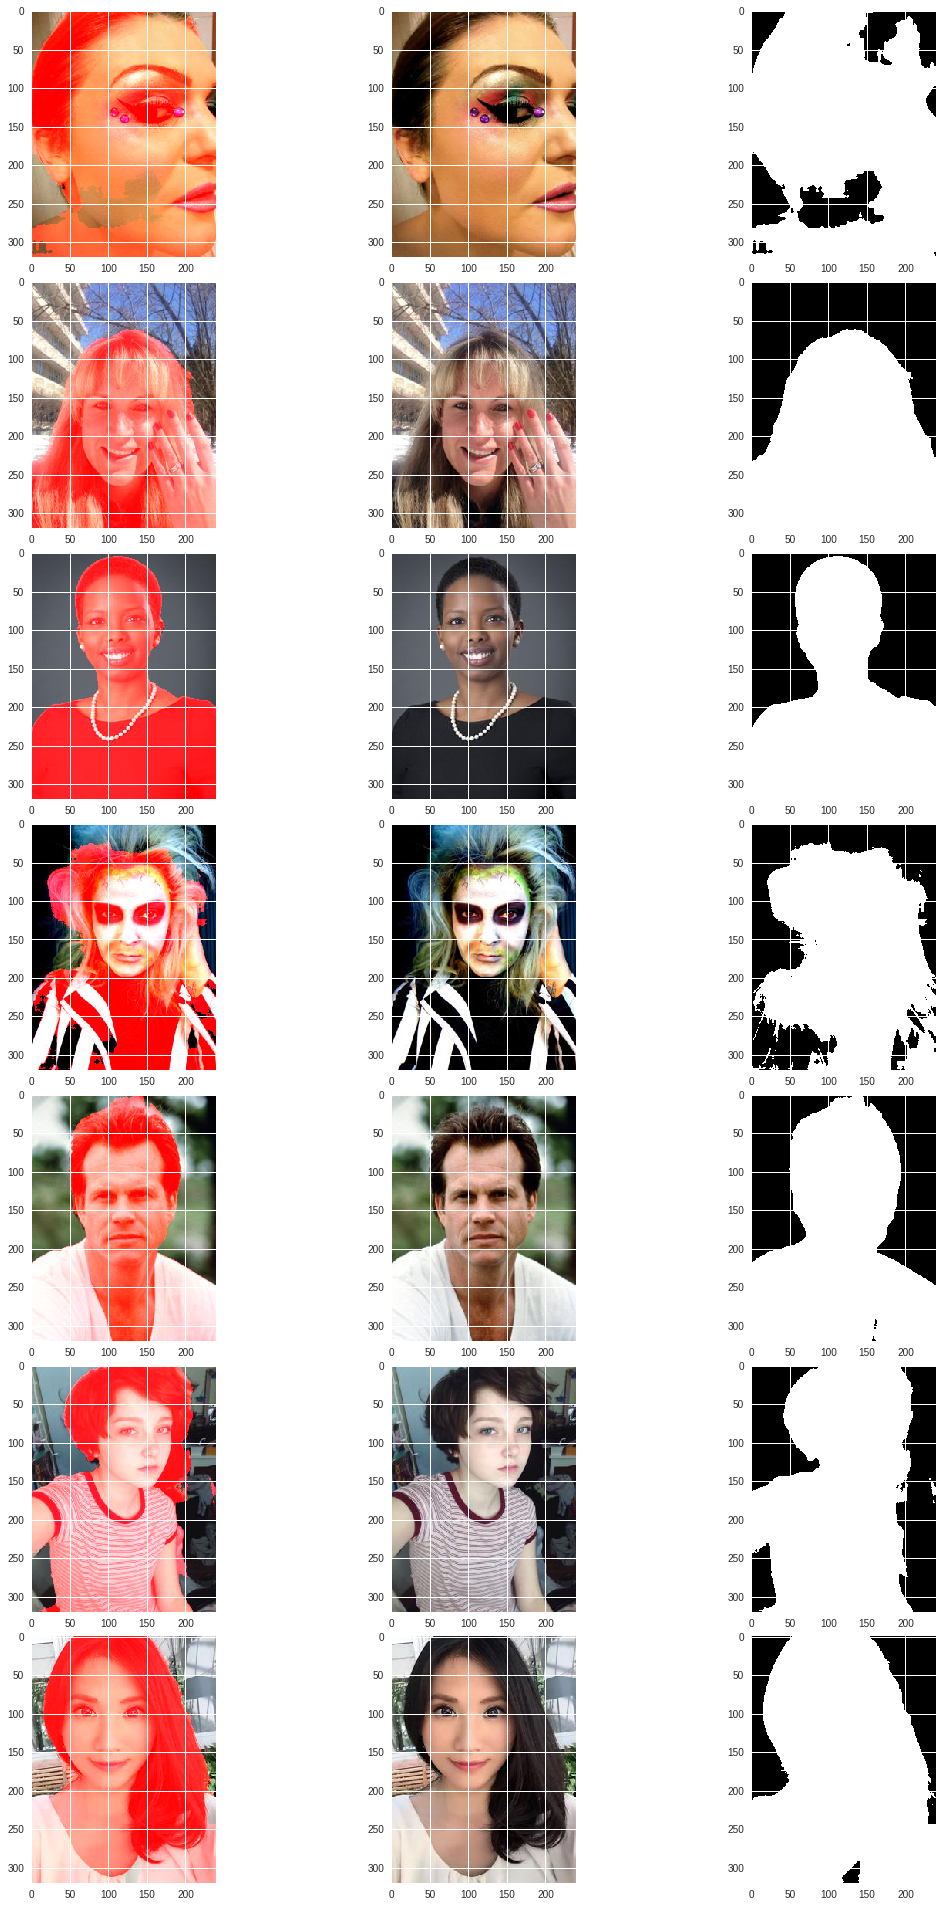

In [9]:

SIZE_OF_RANDOM_CHOOSE = 7
# Считыавем тестовые изображения:
pred_masks_dir = 'output_reduced/test_output'
pred_masks = np.array([np.array(load_img(join(pred_masks_dir, f), grayscale=False)) / 255
                        for f in listdir(pred_masks_dir) if isfile(join(pred_masks_dir, f))])
pred_masks_names = [f[:f.find('.')] for f in listdir(pred_masks_dir) if isfile(join(pred_masks_dir, f))]
pred_masks_names, pred_masks = zip(*sorted(zip(pred_masks_names, pred_masks)))

# Выбираем рандомно несколько изображений:
temp_ = np.array(list(range(0, len(pred_masks_names)))).reshape((-1, 3))
b = temp_[np.random.choice(temp_.shape[0], SIZE_OF_RANDOM_CHOOSE, replace=False), :].flatten()
random_choose_pred_masks_names = np.array(pred_masks_names)[b]
random_choose_pred_masks = np.array(pred_masks)[b]

fig = plt.figure(figsize=(15, 26))
#fig.tight_layout()

subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.1, wspace = 0)

columns = 3
rows = SIZE_OF_RANDOM_CHOOSE
ax = []

for i in range(columns*rows):
    name = random_choose_pred_masks_names[i]
    image = random_choose_pred_masks[i]
    ax.append( fig.add_subplot(rows, columns, i+1) )
    #ax[-1].set_title("ax:"+str(i))  # set title
    plt.imshow(image)

#plt.subplots_adjust(wspace=0, hspace=0)
plt.show()